## Data Preprocessing and Preparation

1. Import the required libraries and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse 
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore") 

solar = pd.read_csv('SolarSurvey.csv')
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Household_ID    3000 non-null   object 
 1   City            3000 non-null   object 
 2   Latitude        2930 non-null   float64
 3   House_Type      2818 non-null   object 
 4   Roof_Type       2661 non-null   object 
 5   Roof_Pitch      2972 non-null   float64
 6   Roof_Azimuth    2916 non-null   float64
 7   Floors          2731 non-null   object 
 8   Financed        3000 non-null   object 
 9   Year            3000 non-null   int64  
 10  Panel_Capacity  3000 non-null   int64  
 11  Shading         2904 non-null   object 
 12  Generation      3000 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 304.8+ KB


2. Exclude the values that doesn't align with the DataDictionary, and drop the missing values. Since the benchmark model are targeted from the year 2019 to 2021, here we follow the same time horizon to train our models.  

In [2]:
solar = solar[solar['Generation'] >= 0]
# ransform Roof Azimuth so that equal angles either side of North are treated the same
solar.loc[solar['Roof_Azimuth'] > 180, 'Roof_Azimuth'] = 360 - solar.loc[solar['Roof_Azimuth'] > 180, 'Roof_Azimuth']
solar = solar[(solar['Year'] >= 2019) & (solar['Year'] <= 2021)]
solar = solar.dropna()

## Candidate Models

Model 1 (M1): Bivariate Linear Regression Model

Examine the correlation coefficient between Generation and all variables. In model 1, I include the two most correlated variables. 

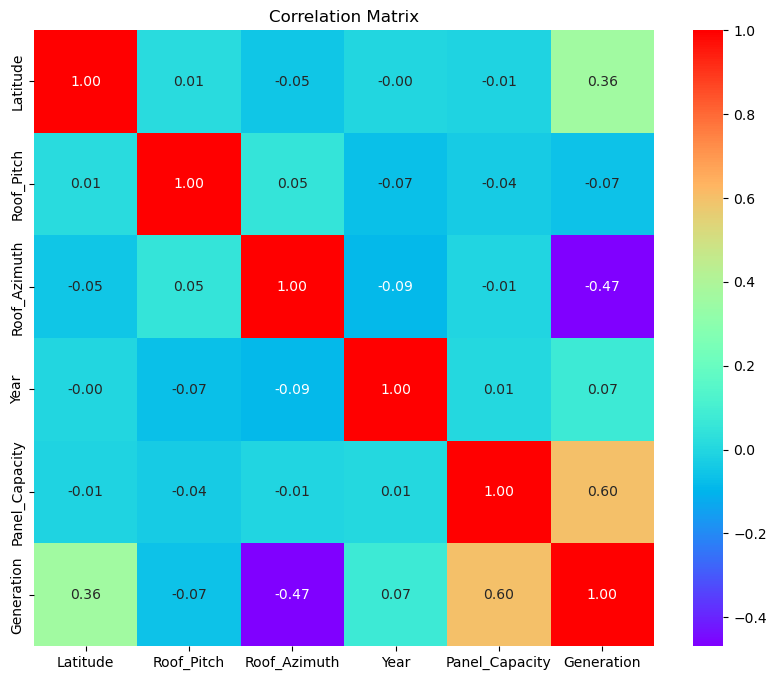

In [3]:
corr_matrix = solar.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='rainbow', cbar=True)

plt.title('Correlation Matrix')
plt.show()

In [4]:
X = solar[['Panel_Capacity','Roof_Azimuth']].to_numpy()
y = solar['Generation'].to_numpy()

X_tv_m1, X_test_m1, y_tv_m1, y_test_m1 = train_test_split(X, y, test_size=0.25, random_state = 1)
X_train_m1, X_vali_m1, y_train_m1, y_vali_m1 = train_test_split(X_tv_m1, y_tv_m1, test_size=1/3, random_state = 1)

linear_reg_M1 = LinearRegression()
linear_reg_M1.fit(X_train_m1, y_train_m1)
print('Intercept: {:.4f}'.format(linear_reg_M1.intercept_))
print('Coefficients: {}'.format(linear_reg_M1.coef_))


Intercept: 389.1268
Coefficients: [  1.78315289 -21.14106505]


### Model 2 (M2): Polynomial Regression Model 

Using the same variables in M1, M2 takes the relationship between panel capacity and generation to the next level. Keeping the linearity of roof azimuth with generation, polynomial relationship is tested out in M2, in hope of better illustrating the relationship between panel capacity and generation. 

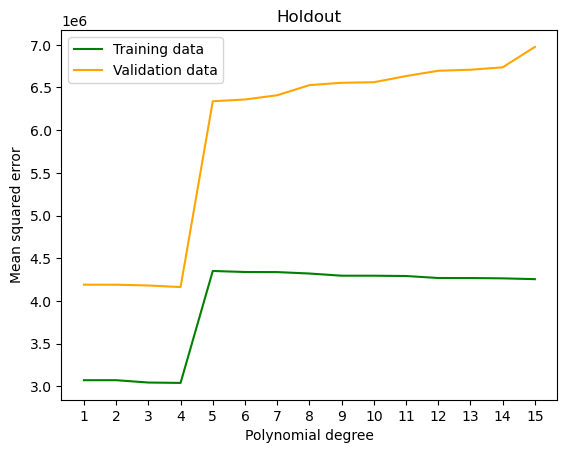

Intercept: -3550.8086
Coefficients: [ 2.16926363e-09 -4.00494241e-06  1.10316169e-03 -1.50236767e-07
  5.78627774e-12  4.93550111e-16 -5.83455352e-17 -1.87988084e-16
  3.78996687e-16  2.89079004e-16  4.12061147e-17  1.79932244e-16
 -4.35802687e-17  2.94991241e-16 -3.03841888e-16 -1.90325339e-16]


In [5]:
max_deg = 20
degrees = range(1, max_deg+1)

poly_data = pd.DataFrame()

for deg in degrees:
    poly_data[f'Panel_Capacity^{deg}'] = solar['Panel_Capacity']**deg

# Add Latitude as a first degree term
poly_data['Roof_Azimuth'] = solar['Roof_Azimuth']

poly_data.insert(0, 'Generation', solar['Generation'])
# poly_data.info()
poly_data = poly_data.to_numpy()

X = poly_data[:, 1:]
y = poly_data[:,0]

X_tv_m2, X_test_m2, y_tv_m2, y_test_m2 = train_test_split(X, y, test_size=0.25, random_state = 1)
X_train_m2, X_vali_m2, y_train_m2, y_vali_m2 = train_test_split(X_tv_m2, y_tv_m2, test_size=1/3, random_state = 1)

mse_train_m2 = []
mse_vali_m2 = []

max_deg = 15
degrees = range(1, max_deg+1)

for deg in degrees:
    X_train_poly = np.concatenate((X_train_m2[:,-1:], X_train_m2[:,:deg]), axis=1)
    X_vali_poly = np.concatenate((X_vali_m2[:,-1:], X_vali_m2[:,:deg]), axis=1)
    linear_reg = LinearRegression()
    linear_reg.fit(X_train_poly,y_train_m2)
    pred_train_m2 = linear_reg.predict(X_train_poly)
    pred_vali_m2 = linear_reg.predict(X_vali_poly)
    mse_train_m2.append(mse(y_train_m2,pred_train_m2))
    mse_vali_m2.append(mse(y_vali_m2,pred_vali_m2))

plt.plot(degrees, mse_train_m2, color = 'green', label = 'Training data')
plt.plot(degrees, mse_vali_m2, color = 'orange', label = 'Validation data')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.title('Holdout')
plt.xticks(degrees)
plt.legend()
plt.show()

X = np.concatenate((poly_data[:,-1:], poly_data[:, 1:5]), axis=1)
y = poly_data[:, 0]

X_tv_m2, X_test_m2, y_tv_m2, y_test_m2 = train_test_split(X, y, test_size=0.25, random_state = 1)
X_train_m2, X_vali_m2, y_train_m2, y_vali_m2 = train_test_split(X_tv_m2, y_tv_m2, test_size=1/3, random_state = 1)

linear_reg_M2 = LinearRegression()
linear_reg_M2.fit(X_train_m2, y_train_m2)

print('Intercept: {:.4f}'.format(linear_reg.intercept_))
print('Coefficients: {}'.format(linear_reg.coef_))

### Model 3 (M3): Multiple-variable Linear Regression Model

Model 3 abandons the polynomial term of M2 (since the model performance is unsatisfying), and includes more explanatory variables into the model. 

In [6]:
solar['Shading_copy'] = solar['City']
solar = pd.get_dummies(solar, columns=['Shading'], drop_first=True)
solar = solar.rename(columns={'Shading_copy': 'Shading'})
solar['Interaction'] = solar['Roof_Pitch'] * solar['Roof_Azimuth']
# solar.info()

X = solar[['Panel_Capacity', 'Shading_Partial','Shading_Significant','Latitude','Roof_Azimuth','Roof_Pitch','Interaction']].to_numpy()
y = solar['Generation'].to_numpy()

X_tv_m3, X_test_m3, y_tv_m3, y_test_m3 = train_test_split(X, y, test_size=0.25, random_state=1)
X_train_m3, X_vali_m3, y_train_m3, y_vali_m3 = train_test_split(X_tv_m3, y_tv_m3, test_size=1/3, random_state=1)

linear_reg_M3 = LinearRegression()
linear_reg_M3.fit(X_train_m3, y_train_m3)

print('Intercept: {}'.format(linear_reg_M3.intercept_))
print('Coefficient: {}'.format(linear_reg_M3.coef_))

X_train_with_const = sm.add_constant(X_train_m3)
model = sm.OLS(y_train_m3, X_train_with_const)
results = model.fit()

print(results.summary())

Intercept: 8455.499143727275
Coefficient: [ 1.61830447e+00 -2.09823167e+03 -5.54105661e+03  2.19821304e+02
 -4.36960818e+00  4.09348804e+01 -6.96931223e-01]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2090.
Date:                Mon, 22 May 2023   Prob (F-statistic):          1.10e-272
Time:                        01:29:10   Log-Likelihood:                -2555.7
No. Observations:                 344   AIC:                             5127.
Df Residuals:                     336   BIC:                             5158.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

Checking the multicollinearity between each variables 

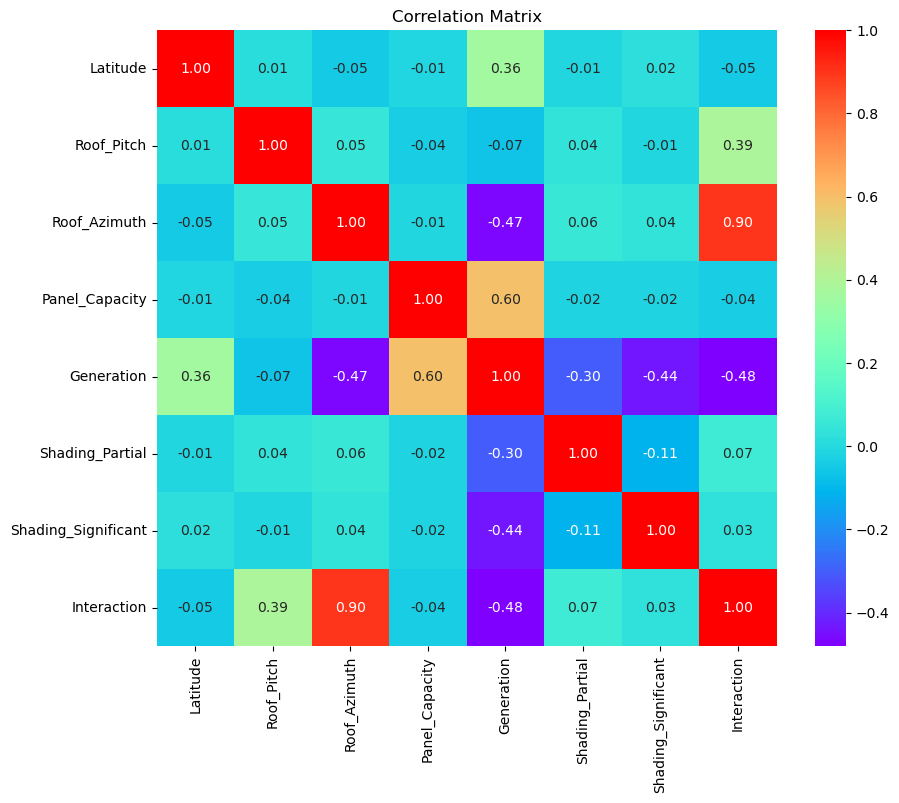

In [7]:
solar_updated = solar.drop("Year", axis=1)
corr_matrix = solar_updated.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='rainbow', cbar=True)

plt.title('Correlation Matrix')
plt.show()

Visualising the interactive relationship between roof pitch and roof azimuth, for the purpose of creating the interaction term in M3. 

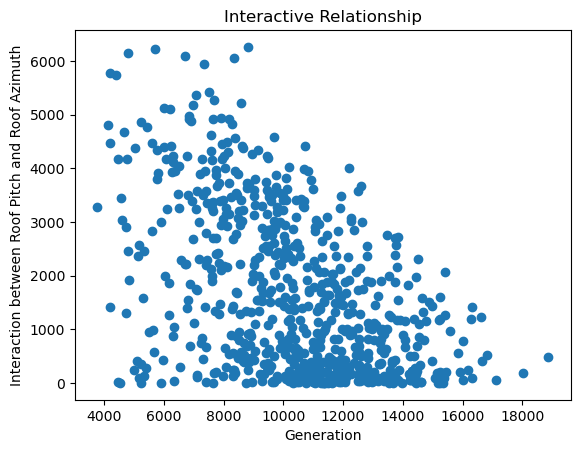

The correlation between generation and interaction term is: -0.4811


In [8]:
plt.scatter(solar['Generation'],solar['Interaction'])
plt.title('Interactive Relationship')
plt.xlabel('Generation')
plt.ylabel('Interaction between Roof Pitch and Roof Azimuth')
plt.show()

correlation_interaction = solar['Generation'].corr(solar['Interaction'])
print('The correlation between generation and interaction term is: {:.4f}'.format(correlation_interaction))

## Model estimation and selection

### Model 1 (M1) 
#### 1. Calculating Validation MSE

In [9]:
y_vali_pred_m1 = linear_reg_M1.predict(X_vali_m1)
mse_vali_m1 = mse(y_vali_m1, y_vali_pred_m1)

print("Validation mse: {:.4f}".format(mse_vali_m1))

Validation mse: 4190725.9271


#### 2. Testing the residual assumptions

a. Homoskedasticity 

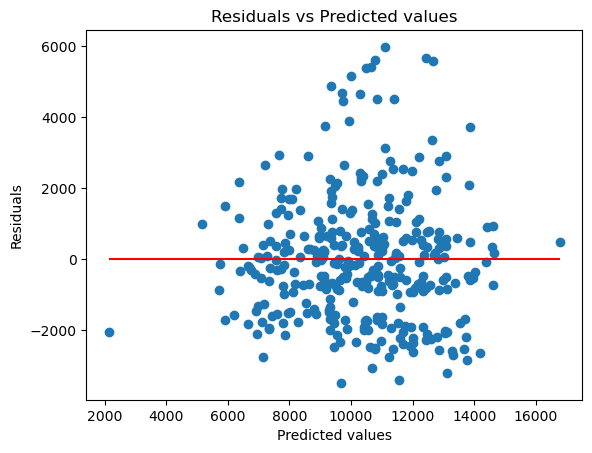

In [10]:
y_train_pred_m1 = linear_reg_M1.predict(X_train_m1)

# Residuals Scatter Plot (based on training set)
residuals_train_m1 = y_train_pred_m1 - y_train_m1

plt.scatter(y_train_pred_m1, residuals_train_m1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.hlines(y = 0, xmin = y_train_pred_m1.min(), xmax = y_train_pred_m1.max(), color = 'red')
plt.show()

b. Normality

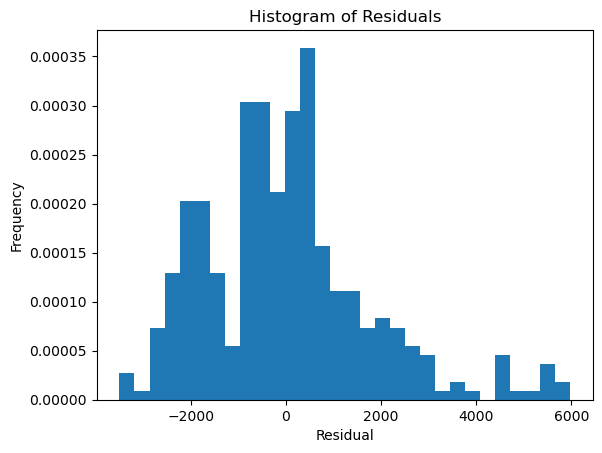

In [11]:
plt.hist(residuals_train_m1, bins=30, density=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Model 2 (M2) 
#### 1. Calculating Validation MSE

In [12]:
y_vali_pred_m2 = linear_reg_M2.predict(X_vali_m2)
mse_vali_m2 = mse(y_vali_m2, y_vali_pred_m2)

print("Validation mse: {:.4f}".format(mse_vali_m2))

Validation mse: 4162618.3525


#### 2. Testing the residual assumptions

a. Homoskedasticity 

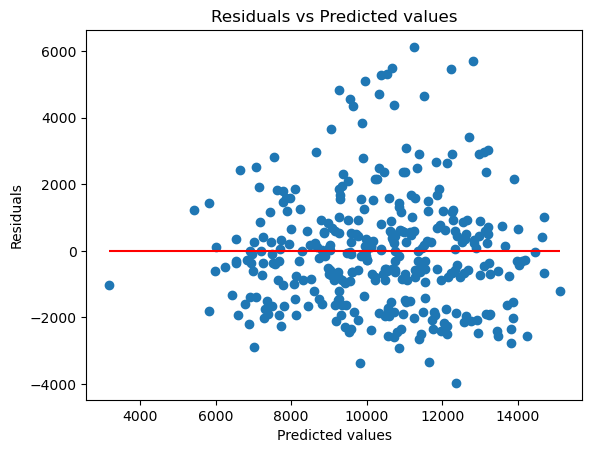

In [13]:
y_train_pred_m2 = linear_reg_M2.predict(X_train_m2)

# Residuals Scatter Plot (based on training set)
residuals_train_m2 = y_train_pred_m2 - y_train_m2

plt.scatter(y_train_pred_m2, residuals_train_m2)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.hlines(y = 0, xmin = y_train_pred_m2.min(), xmax = y_train_pred_m2.max(), color = 'red')
plt.show()

b. Normality

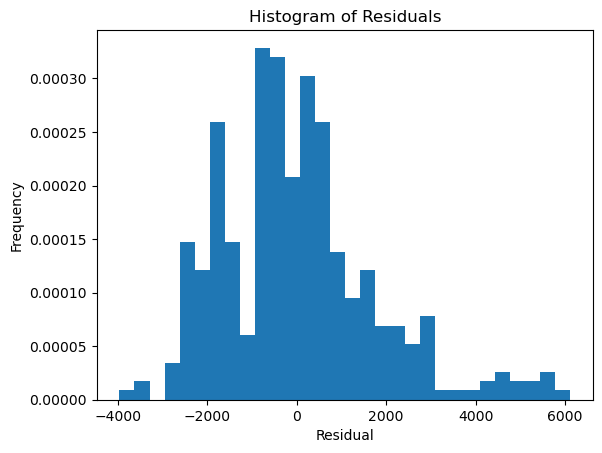

In [14]:
plt.hist(residuals_train_m2, bins=30, density=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Model 3 (M3) 
#### 1. Calculating Validation MSE

In [15]:
y_vali_pred_m3 = linear_reg_M3.predict(X_vali_m3)
mse_vali_m3 = mse(y_vali_m3, y_vali_pred_m3)

print("Validation mse: {:.4f}".format(mse_vali_m3))

Validation mse: 170474.8097


#### 2. Testing the residual assumptions

a. Homoskedasticity 

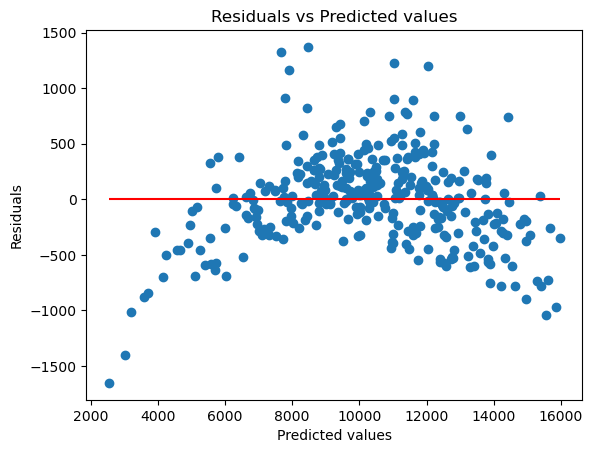

In [16]:
y_train_pred_m3 = linear_reg_M3.predict(X_train_m3)

# Residuals Scatter Plot (based on training set)
residuals_train_m3 = y_train_pred_m3 - y_train_m3

plt.scatter(y_train_pred_m3, residuals_train_m3)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.hlines(y = 0, xmin = y_train_pred_m3.min(), xmax = y_train_pred_m3.max(), color = 'red')
plt.show()

b. Normality

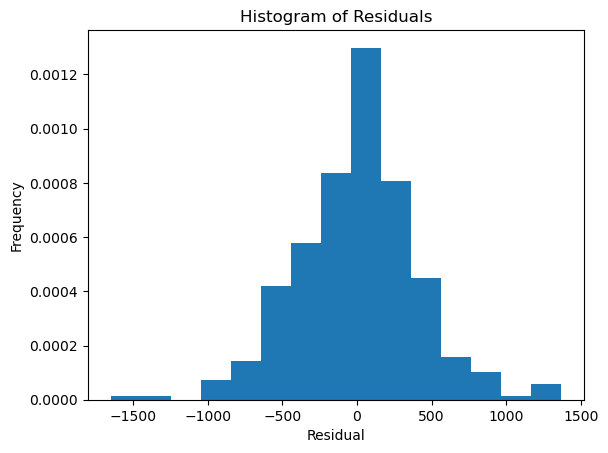

In [17]:
plt.hist(residuals_train_m3, bins=15, density=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model evaluation

The selected model based on the calculated validation MSE is Model 3. Based on the combined training and validation sets, M3 is re-estimated to compute its test MSE. 

In [18]:
# Fit model to the combined training and validation data
linear_reg_M3.fit(X_tv_m3, y_tv_m3)

# Predict on the test data
y_test_pred_m3 = linear_reg_M3.predict(X_test_m3)
mse_test_m3 = mse(y_test_m3, y_test_pred_m3)

print("Test MSE: {:.4f}".format(mse_test_m3))

Test MSE: 176382.6604


### Benchmark Models 

#### Benchmark 1 (B1)

In [19]:
X = solar.drop('Generation', axis=1)
y = solar['Generation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

train_df = pd.concat([X_train, y_train], axis=1)

avg_generation_train = train_df.groupby('City')['Generation'].mean().reset_index()
avg_generation_train.columns = ['City', 'Avg_Generation']

X_test = pd.merge(X_test, avg_generation_train, on='City', how='left')
bm1_pred_test = X_test['Avg_Generation']

mse_test = mse(y_test, bm1_pred_test)

print("Test MSE: {:.4f}".format(mse_test))

Test MSE: 5219490.0290


#### Benchmark 2 (B2)

In [20]:
X = solar.drop('Generation', axis=1)
y = solar['Generation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

train_df = pd.concat([X_train, y_train], axis=1)

avg_generation_train = train_df.groupby(['City', 'Panel_Capacity'])['Generation'].mean().reset_index()
avg_generation_train.columns = ['City', 'Panel_Capacity', 'Avg_Generation']

X_test = pd.merge(X_test, avg_generation_train, on=['City', 'Panel_Capacity'], how='left')

# Fill NaNs with the overall average of 'Generation' from the training data
overall_avg_generation = train_df['Generation'].mean()
X_test['Avg_Generation'].fillna(overall_avg_generation, inplace=True)

bm1_pred_test = X_test['Avg_Generation']

mse_test = mse(y_test, bm1_pred_test)

print("Test MSE: {:.4f}".format(mse_test))

Test MSE: 3162064.6951
